# July 31, Aug 23 2024: check if chains have converged

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob

import arviz as az

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 10
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'ses'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')

0

In [5]:
SBM_path

'/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/model-fits'

In [6]:
args.dc, args.sbm = True, 'o'

args.force_niter = 10000 #40000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-dc-o'

In [7]:
def collect_sbm_files(args, sbm_files):
    sbm_dfs = []
    for sbm_file in tqdm(sbm_files):
        fs = sbm_file.split('/')
        with open(sbm_file, 'rb') as f:
            [bs, Bs, Bes, dls] = pickle.load(f)

        df = pd.DataFrame({})
        for desc in fs[-4].split('_'): # sub ses
            D = desc.split('-')
            df[D[0]] = D[1:]

        D = fs[-3] # sbm
        df['sbm'] = D

        D = fs[-2].split('-') # B
        df[D[0]] = '_'.join(D[1:])

        df['Bes'] = [Bes[0] if args.sbm in ['h'] else Bes]

        sbm_dfs += [df]
    sbm_dfs = pd.concat(sbm_dfs).reset_index(drop=True)
    sbm_dfs.sort_values(['sub', 'ses', 'sbm', 'B'])
    return sbm_dfs

dfs_file = f'{DIAG_path}/{SBM}_desc-diagnostics-dfs.npy'
# if os.path.exists(dfs_file):
#     # with open(dfs_file, 'rb') as f:
#     #     sbm_dfs = pickle.load(f)
#     pass
# else:
sbm_files = sorted(glob.glob(f'{SBM_path}/*/{SBM}/*/desc-partitions.pkl', recursive=True))
sbm_dfs = collect_sbm_files(args, sbm_files)
    # with open(dfs_file, 'wb') as f:
    #     pickle.dump(sbm_dfs, f)

100%|██████████| 150/150 [00:14<00:00, 10.33it/s]


In [8]:
sbm_dfs

sub ses       sbm    B  \
0    SLC01   1  sbm-dc-o    1   
1    SLC01   1  sbm-dc-o  122   
2    SLC01   1  sbm-dc-o  162   
3    SLC01   1  sbm-dc-o   41   
4    SLC01   1  sbm-dc-o   82   
..     ...  ..       ...  ...   
145  SLC10   3  sbm-dc-o    1   
146  SLC10   3  sbm-dc-o  122   
147  SLC10   3  sbm-dc-o  162   
148  SLC10   3  sbm-dc-o   41   
149  SLC10   3  sbm-dc-o   82   

                                                   Bes  
0    [4.998000938275898, 4.9969541313487325, 4.9945...  
1    [117.68214875099112, 117.20218444114766, 116.6...  
2    [157.5494688927804, 155.01900026776272, 155.12...  
3    [40.46503849426499, 40.46390403952203, 40.3546...  
4    [79.6286629912831, 79.59604822968674, 79.63287...  
..                                                 ...  
145  [3.9840576276973803, 3.9881282988520694, 3.993...  
146  [119.1743345357165, 118.90554135587291, 117.79...  
147  [157.4372647481495, 155.3002611677288, 152.552...  
148  [40.55358342371625, 40.543744079523734, 40.481...  
149  [80.26261610873411, 80.06905370950096, 80.0521...  

[150 rows x 5 columns]

['sub', 'ses']

30it [01:17,  2.58s/it]


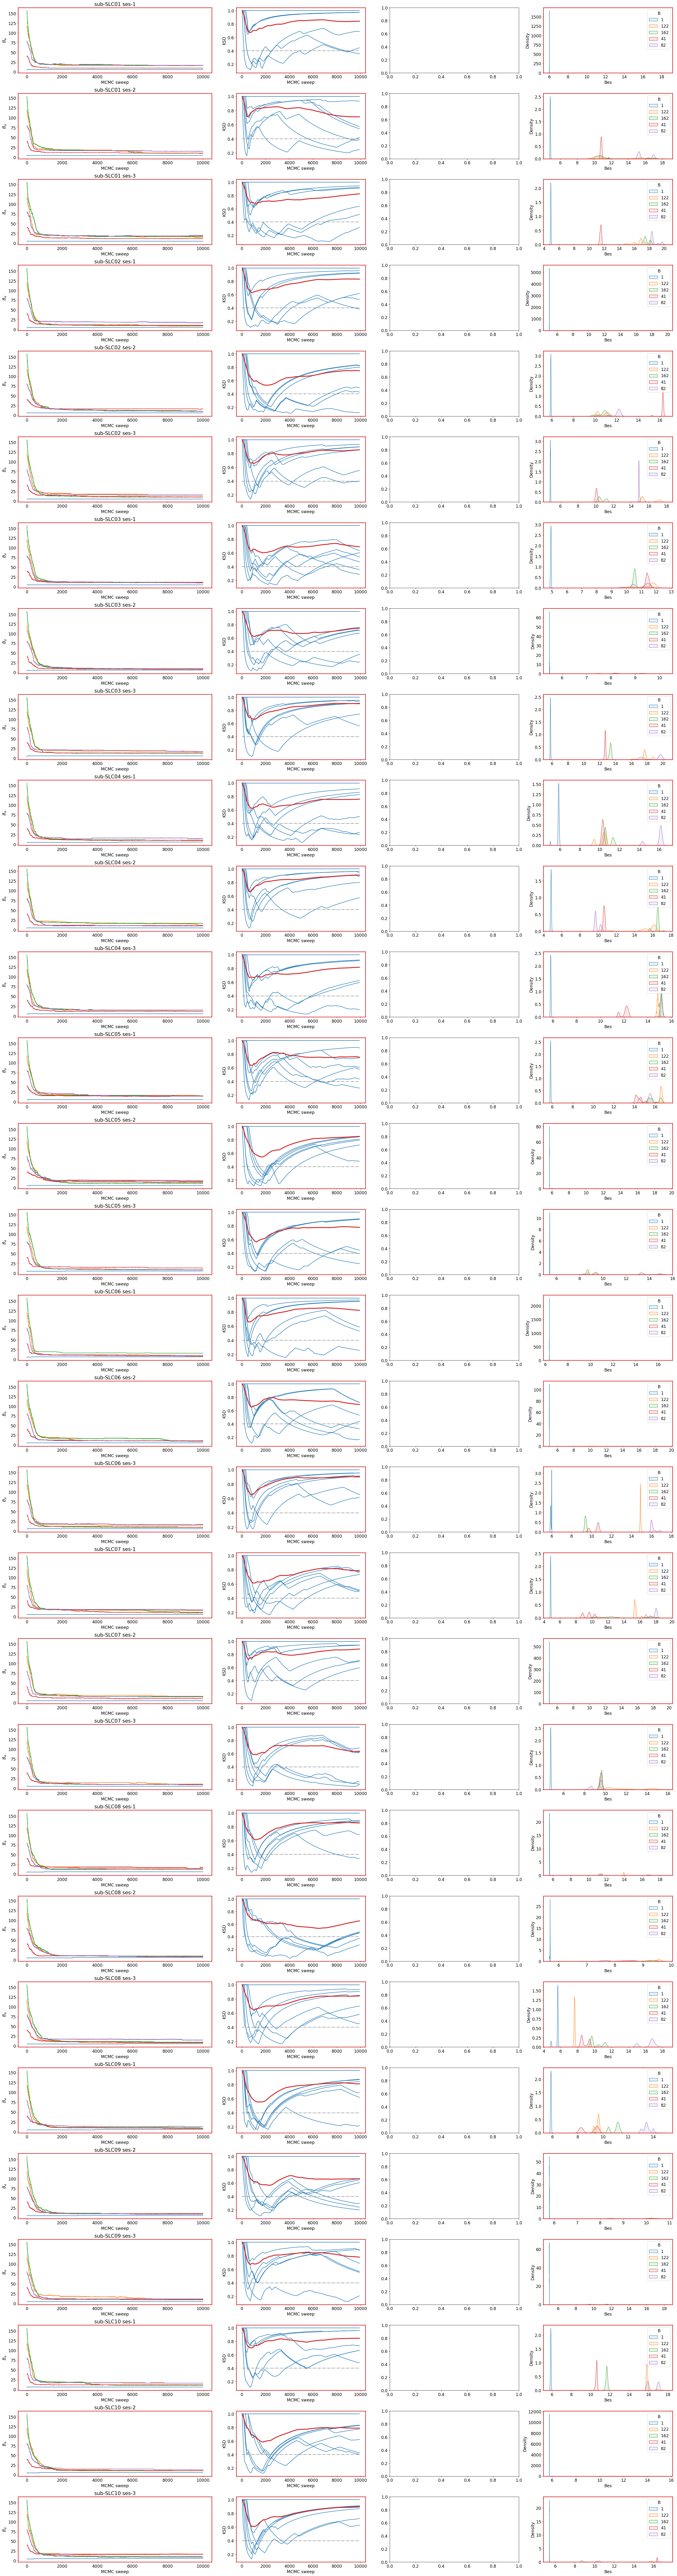

In [9]:
def get_chains_df(args, group, groupby):
    complete_chains_df = []
    converged_chains_df = []
    for idx, row in group.iterrows():
        df = pd.DataFrame({})
        for col in groupby:
            df[col] = [row[col]]

        df['B'] = [row['B']]  
        df['Bes'] = [row['Bes']]
        complete_chains_df += [df]
        
        df = pd.DataFrame({})
        for col in groupby:
            df[col] = [row[col]]
        
        df['B'] = [row['B']]
        df['Bes'] = [row['Bes'][-args.num_draws:]]
        converged_chains_df += [df]
    complete_chains_df = pd.concat(complete_chains_df).reset_index(drop=True)
    converged_chains_df = pd.concat(converged_chains_df).reset_index(drop=True)
    return complete_chains_df, converged_chains_df

def KSD(args, chains_df):
    chain_idxs = chains_df.index.to_list()
    
    ksd_dfs = []
    for idx1, idx2 in (combinations(chain_idxs, 2)):
        Bes_ch1 = chains_df.iloc[idx1]['Bes']
        Bes_ch2 = chains_df.iloc[idx2]['Bes']
        Ds = []
        ts = np.arange(10, args.force_niter, 100)
        for t in ts:
            res = stats.ks_2samp(Bes_ch1[:t], Bes_ch2[:t])
            Ds.append(res.statistic)
        df = pd.DataFrame({
            'ch1': [idx1] * len(Ds),
            'ch2': [idx2] * len(Ds),
            't': ts,
            'D': Ds,
        })
        ksd_dfs.append(df)
    ksd_dfs = pd.concat(ksd_dfs).reset_index(drop=True)
    return ksd_dfs

def plot_KSD(args, chains_df, ksd_dfs, ax):
    chain_idxs = chains_df.index.to_list()
    Ds = []
    for idx1, idx2 in combinations(chain_idxs, 2):
        t_D = ksd_dfs[
            (ksd_dfs['ch1'] == idx1) &
            (ksd_dfs['ch2'] == idx2)
        ][['t', 'D']].to_numpy()
        Ds += [t_D[:, 1]]
        ax.plot(t_D[:, 0], t_D[:, 1], c='tab:blue')
    Ds = np.stack(Ds, axis=-1)
    ax.plot(t_D[:, 0], np.mean(Ds, axis=-1), c='tab:red', linewidth=3)
    ax.plot(t_D[:, 0], args.epsilon * np.ones_like(t_D[:, 0]), c='tab:grey', linestyle='-.')
    T = Ds.shape[0]
    return np.all(Ds[T//2:, :] < args.epsilon)

def Rhat(args, chains_df):
    chain_idxs = chains_df.index.to_list()
    chains = np.stack(chains_df['Bes'].to_list(), axis=0)
    
    ts = np.arange(10, chains.shape[-1], 100)
    rhats = np.zeros_like(ts)
    for i, t in enumerate(ts):
        rhats[i] = az.rhat(chains[:, :t])
    return ts, rhats

def indicate_unmizing(args, ax):
    for spine in ax.spines.values():
        spine.set_color('tab:red')
        spine.set_linewidth(2)
    return None

figfile = f'{DIAG_path}/{SBM}_desc-diagnostics.png'
if os.path.exists(figfile):
    display(Image(figfile))
else:
    i = np.where(sbm_dfs.columns == args.DATA_UNIT)[0][0]
    groupby = list(sbm_dfs.columns)[:i+1]
    display(groupby)

    def create_diagnostics_plot(args, sbm_dfs, groupby):
        num_keys = len(sbm_dfs.groupby(by=groupby))
        nrows = num_keys if num_keys > 1 else 2
        ncols = 4
        fig, axs = plt.subplots(
            nrows=nrows, ncols=ncols, 
            figsize=(7*ncols+3.5, 4*nrows), width_ratios=[1.5, 1, 1, 1], 
            dpi=90
        )
        fig.tight_layout(h_pad=3, w_pad=3)
        converged_dfs = []
        for idx, (key, group) in tqdm(enumerate(sbm_dfs.groupby(by=groupby))):
            df = pd.DataFrame({})
            for g, k in zip(groupby, key):
                df[g] = [k]
            
            complete_chains_df, converged_chains_df = get_chains_df(args, group, groupby)
            
            ax = axs[idx, 1]
            ksd_dfs = KSD(args, complete_chains_df)
            converged = plot_KSD(args, complete_chains_df, ksd_dfs, ax)
            ax.set(xlabel=f'MCMC sweep', ylabel=f'KSD')
            if not converged: indicate_unmizing(args, ax)

            df['converged'] = [converged]

            title = []
            for col in groupby:
                title += [f'{col}-{group.iloc[0][col]}']
            title = ' '.join(title)
            
            ax = axs[idx, 0]
            for i, r in complete_chains_df.iterrows():
                ax.plot(r['Bes'])
            ax.set(title=f'{title}', ylabel='$B_e$', xlabel='MCMC sweep')
            if not converged: indicate_unmizing(args, ax)
            
            # ax = axs[idx, 2]
            # ts, rhats = Rhat(args, complete_chains_df)
            # ax.plot(ts, rhats)
            # ax.set(xlabel=f'MCMC sweep', ylabel='$\hat{R}$')
            # if not converged: indicate_unmizing(args, ax)
            
            ax = axs[idx, 3]
            chs_df = converged_chains_df.explode('Bes')
            sns.kdeplot(data=chs_df, x='Bes', hue='B', fill=True, palette='tab10', alpha=0.1, ax=ax)
            if not converged: indicate_unmizing(args, ax)

            converged_dfs += [df]
        converged_dfs = pd.concat(converged_dfs).reset_index(drop=True)
        return fig, converged_dfs
    fig, converged_dfs = create_diagnostics_plot(args, sbm_dfs, groupby)

In [10]:
fig.savefig(f'{DIAG_path}/{SBM}_desc-trace-KSD-Rhat-dist.png', bbox_inches='tight')